# SpatialMouse - Deconvolve 2 xDbit Kidney sections using cell2location

- Followed this tutorial: https://docs.scvi-tools.org/en/stable/tutorials/notebooks/cell2location_lymph_node_spatial_tutorial.html
- More updated tutorial here: https://github.com/BayraktarLab/cell2location/blob/master/docs/notebooks/cell2location_tutorial.ipynb

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
## Import the custom library
import os
import sys

# add xDbit toolbox path to path variable
module_path = os.path.abspath("../../")
if module_path not in sys.path:
    sys.path.append(module_path)

import dbitx_funcs as db

import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
import seaborn as sns
import scvi
import cell2location

Global seed set to 0


In [12]:
import random

In [3]:
plt.rcParams['figure.dpi'] = 80
plt.style.use('default')

## Set results directory

In [4]:
data_dir = "out"
results_folder = os.path.join(data_dir, "deconvolution")

# create model path if necessary
Path(results_folder).mkdir(parents=True, exist_ok=True)

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = os.path.join(results_folder, 'reference_signatures')

# Load data

## Generate single-cell dataset

The dataset from this publication was used: https://www.nature.com/articles/s41467-021-22266-1 <br>
Dataset was downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE157079

### Load raw single-cell data

In [5]:
# count matrix file
sc_file = "/home/hpc/johannes.wirth/data/datasets/MouseKidneyCellAtlas/GSE157079_P0_adult_counts.csv"

# load metadata
clusters = pd.read_csv("/home/hpc/johannes.wirth/data/datasets/MouseKidneyCellAtlas/GSE157079_P0_adult_clusters.txt.gz", 
                       sep="\t", usecols=["barcodes", "clusters"]).set_index("barcodes")
umap = pd.read_csv("/home/hpc/johannes.wirth/data/datasets/MouseKidneyCellAtlas/GSE157079_P0_adult_umap.txt.gz", 
                       sep="\t", index_col=0)
pheno = pd.read_csv("/home/hpc/johannes.wirth/data/datasets/MouseKidneyCellAtlas/GSE157079_P0_adult_pheno.txt.gz", 
                       sep="\t", usecols=['barcodes', 'pheno']).set_index("barcodes")

In [10]:
# load matrix
scadata = sc.read_text(sc_file, delimiter=",").transpose()

# add metadata
scadata.obs["celltype"] = clusters
scadata.obs[["UMAP1", "UMAP2"]] = umap
scadata.obsm["X_umap"] = scadata.obs[["UMAP1", "UMAP2"]].values
scadata.obs["pheno"] = pheno

In [11]:
scadata

AnnData object with n_obs × n_vars = 43636 × 31053
    obs: 'celltype', 'UMAP1', 'UMAP2', 'pheno'
    obsm: 'X_umap'

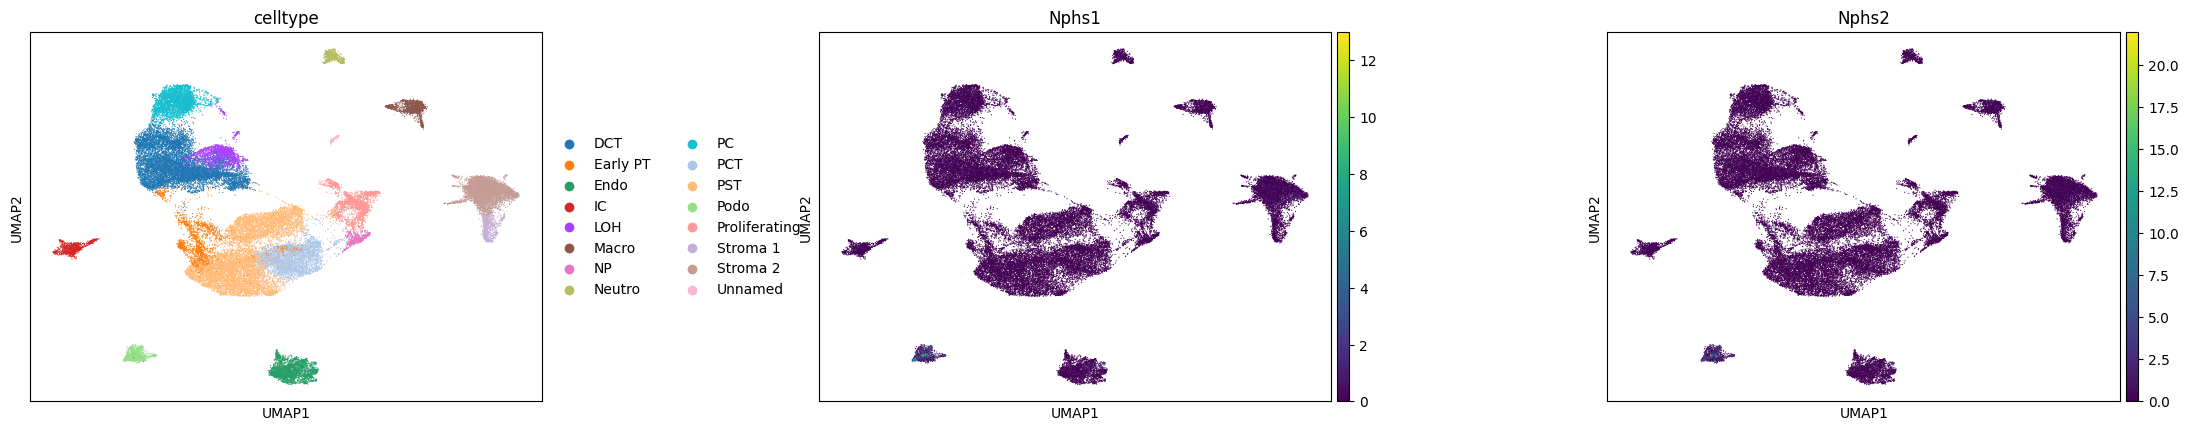

In [12]:
sc.pl.umap(scadata, color=["celltype", "Nphs1", "Nphs2"], wspace=0.4)

### Save resulting dataset

In [13]:
adatafile = os.path.join(data_dir, "GSE157079_P0_adult.h5ad")

In [14]:
scadata.write(adatafile)

### Reload dataset

In [15]:
scadata = sc.read(adatafile)

### Preprocessing

In [16]:
scadata = db.tl.standard_preprocessing(scadata, dim_reduction=False) # preprocessing without dimensionality reduction to keep UMAP from publication

Store raw counts in adata.layers['counts']...
Normalization, log-transformation...
Calculate highly-variable genes across all samples using seurat flavor...


In [17]:
scadata

AnnData object with n_obs × n_vars = 43636 × 31053
    obs: 'celltype', 'UMAP1', 'UMAP2', 'pheno'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'log1p', 'hvg'
    obsm: 'X_umap'
    layers: 'counts', 'norm_counts'

### Save preprocessed data

In [18]:
pp_file = os.path.join(data_dir, "GSE157079_P0_adult_pp.h5ad")

In [19]:
scadata.write(pp_file)

### Reload preprocessed data

In [17]:
scadata = sc.read(pp_file)

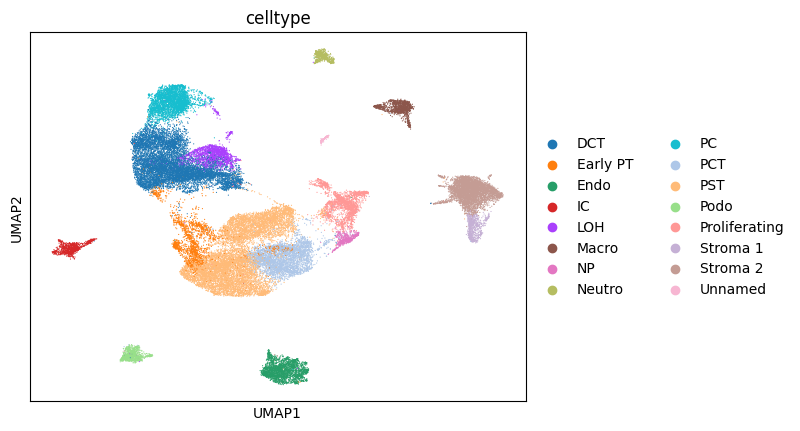

In [20]:
sc.pl.umap(scadata, color=["celltype"], wspace=0.4)

### Select only adult dataset and save again

Since our spatial data is from 3 months old mice we use here the adult dataset only.

In [21]:
# select adult dataset
scadata = scadata[scadata.obs['pheno'] == 'Adult', :].copy()

In [22]:
scadata

AnnData object with n_obs × n_vars = 18498 × 31053
    obs: 'celltype', 'UMAP1', 'UMAP2', 'pheno'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'log1p', 'hvg'
    obsm: 'X_umap'
    layers: 'counts', 'norm_counts'

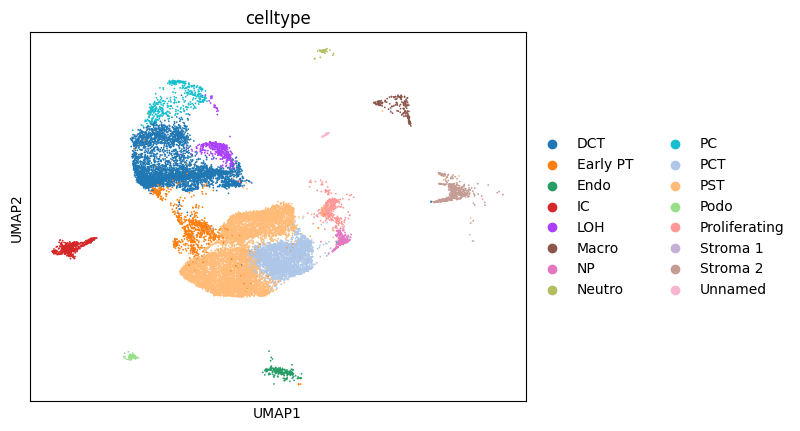

In [23]:
sc.pl.umap(scadata, color=["celltype"])

### Save adult sc dataset

In [6]:
adult_file = os.path.join(data_dir, "GSE157079_adult_pp.h5ad")

In [25]:
scadata.write(adult_file)

### Reload dataset

In [7]:
scadata = sc.read(adult_file)

## Load ST data

In [8]:
st_file = os.path.join(data_dir, "Kidney_adata_pp_wohires_deg.h5ad")

In [9]:
stadata = sc.read(st_file)

In [10]:
stadata

AnnData object with n_obs × n_vars = 4099 × 15027
    obs: 'array_row', 'array_col', 'um_row', 'um_col', 'id', 'pixel_row', 'pixel_col', 'dapi_mean', 'dapi_mean_norm', 'experiment_id', 'organism', 'age', 'organ', 'age_months', 'mouse_id', 'exp_date', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'CT010467.1_pct', 'leiden_uncorrected', 'leiden', 'leiden_coarse'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'deg_leiden', 'deg_leiden_coarse', 'experiment_id_colors', 'hvg', 'id_colors', 'leiden', 'leiden_coarse_colors', 'leiden_colors', 'log1p', 'matchedVis', 'neighbors', 'neighbors_uncorrected', 'organ_colors', 'pca', 'registered', 'spatial', 'tsne', 'umap'
    obsm: 'X_emb', 'X_pca', 'X_scanorama', 'X_tsne', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'norm_counts'
    obsp

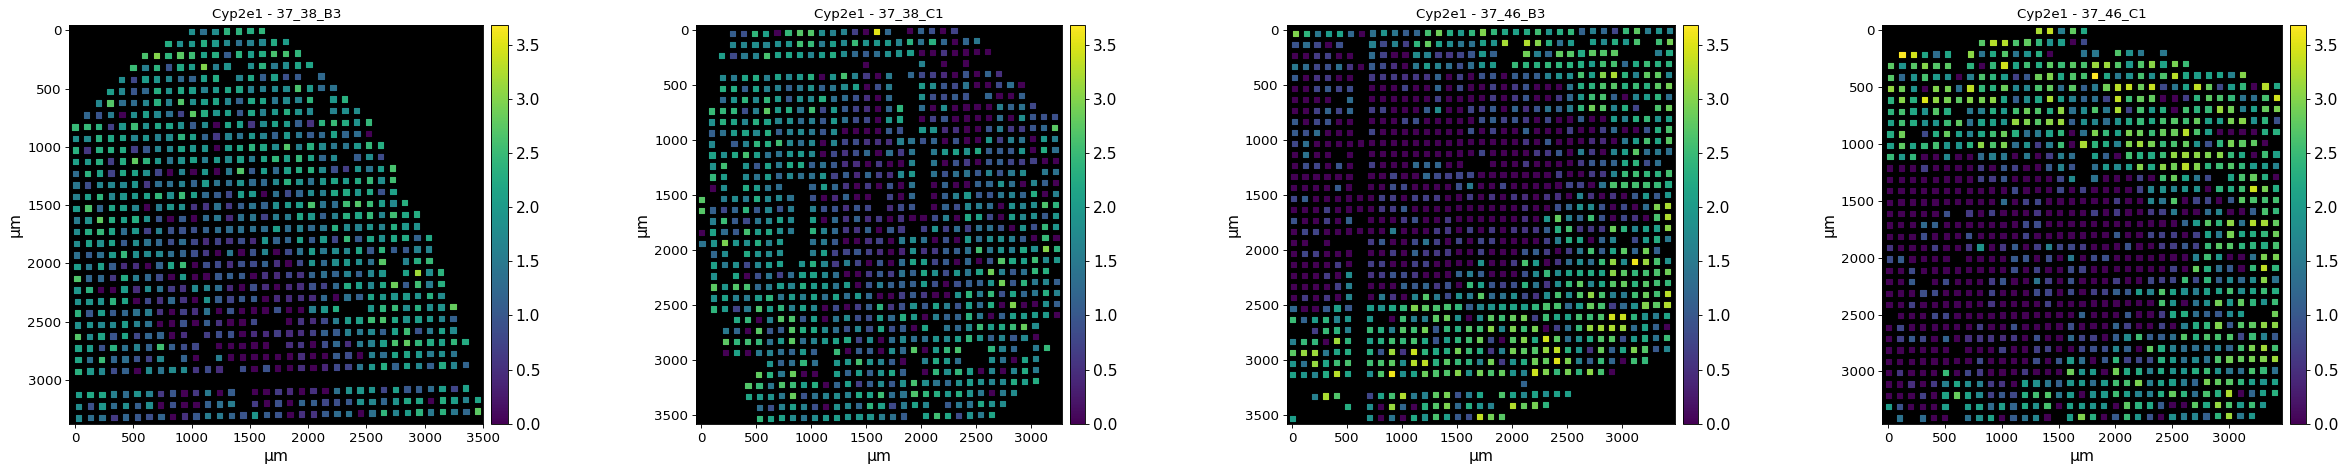

In [11]:
db.pl.spatial(stadata, keys='Cyp2e1', groupby='id')

## Select two sections

In figure 4 and 5 we focused on the analysis of the section `37_46_B3`. For the vessel-centered view in a possible figure 6 we would need to analyze `37_46_C1` in addition.

In [13]:
groupby = 'id'
indices = ["37_46_B3", "37_46_C1"]

stadatas = {}
for idx in indices:
    stadatas[idx] = db.tl.extract_groups(adata=stadata, groupby='id', groups=idx)

In [14]:
stadatas

{'37_46_B3': AnnData object with n_obs × n_vars = 1116 × 15027
     obs: 'array_row', 'array_col', 'um_row', 'um_col', 'id', 'pixel_row', 'pixel_col', 'dapi_mean', 'dapi_mean_norm', 'experiment_id', 'organism', 'age', 'organ', 'age_months', 'mouse_id', 'exp_date', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'CT010467.1_pct', 'leiden_uncorrected', 'leiden', 'leiden_coarse'
     var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'deg_leiden', 'deg_leiden_coarse', 'experiment_id_colors', 'hvg', 'id_colors', 'leiden', 'leiden_coarse_colors', 'leiden_colors', 'log1p', 'matchedVis', 'neighbors', 'neighbors_uncorrected', 'organ_colors', 'pca', 'registered', 'spatial', 'tsne', 'umap'
     obsm: 'X_emb', 'X_pca', 'X_scanorama', 'X_tsne', 'X_umap', 'spatial'
     varm: 'PCs'
     layers: 'counts', 'no

37_46_B3


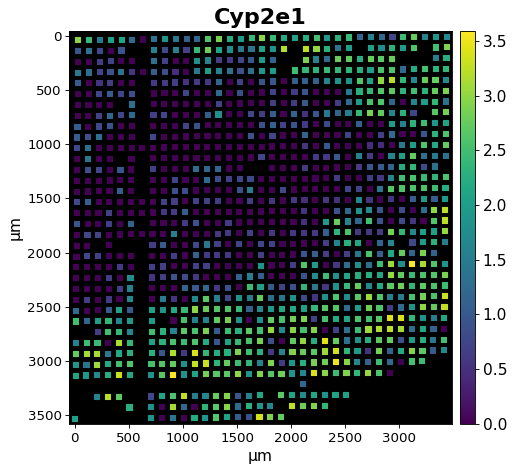

37_46_C1


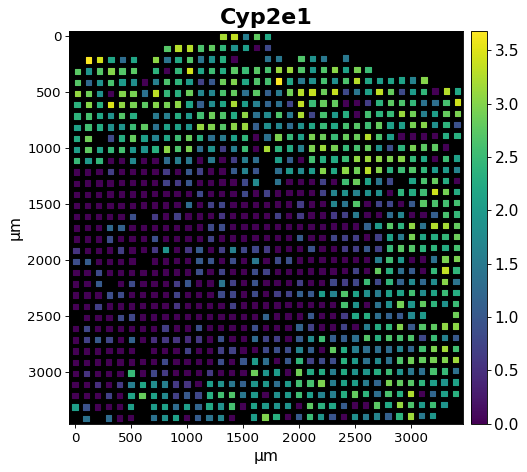

In [15]:
for i, adata in stadatas.items():
    print(i)
    db.pl.spatial(adata, keys='Cyp2e1', groupby='id')

## Remove mito genes

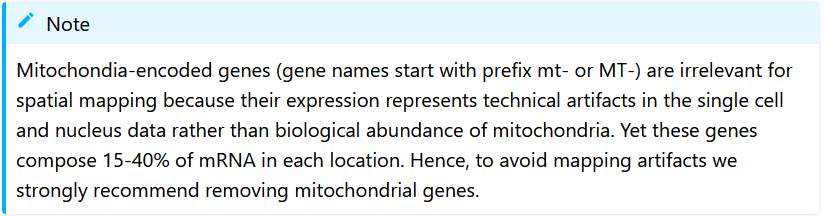
https://docs.scvi-tools.org/en/stable/tutorials/notebooks/cell2location_lymph_node_spatial_tutorial.html

In [18]:
# search for mito genes and filter them out
scadata.var['mt'] = scadata.var_names.str.contains('MT-', case=False)
scadata = scadata[:, ~scadata.var['mt'].values].copy()

# same for spatial data
for i, stadata in stadatas.items():
    stadata.var['mt'] = stadata.var_names.str.contains('MT-', case=False)
    stadatas[i] = stadata[:, ~stadata.var['mt'].values].copy()

## Filtering of sc data - Cell2location

/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


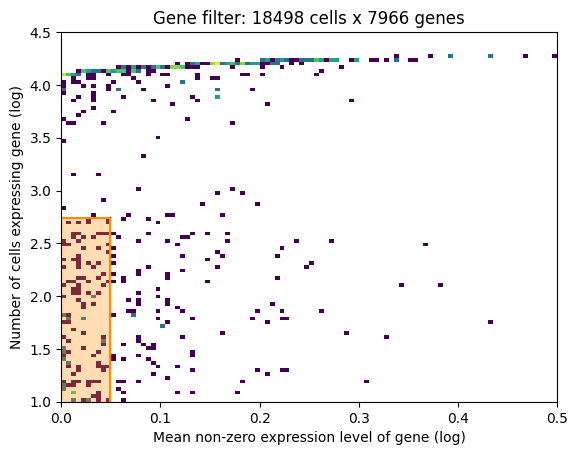

In [20]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(scadata, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
scadata = scadata[:, selected].copy()

# Deconvolution

## Estimation of reference cell type signatures (NB regression)

## Train model

In [21]:
from cell2location.models import RegressionModel
RegressionModel.setup_anndata(scadata, layer='counts', labels_key='celltype')

In [22]:
sc_model = RegressionModel(scadata)

In [23]:
sc_model.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': 'celltype',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 18498 │
│          n_vars          │ 7966  │
│         n_batch          │   1   │
│         n_labels         │  16   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltype'] │      DCT      │          0          │
│                       │   Early PT    │          1          │
│                       │     Endo      │          2          │
│                       │      IC       │          3          │
│                       │      LOH      │          4          │
│                       │     Macro     │          5          │
│                       │      NP       │          6          │
│                       │    Neutro     │          7          │
│                       │      PC       │          8          │
│                       │      PCT      │          9          │
│                       │      PST      │         10          │
│                       │     Podo      │         11          │
│                       │ Proliferating │         12          │
│                       │   Stroma 1    │         13          │
│                       │   Stroma 2    │         14          │
│                       │    Unnamed    │         15          │
└───────────────────────┴───────────────┴─────────────────────┘

In [24]:
sc_model.train(max_epochs=250, use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (8) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/250:   0%|          | 0/250 [00:00<?, ?it/s]

/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/torch/distributions/gamma.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /lustre/groups/hpc/meier_lab/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  self.rate * value - torch.lgamma(self.concentration))


Epoch 250/250: 100%|██████████| 250/250 [03:07<00:00,  1.33it/s, v_num=1, elbo_train=6.73e+7]


### Check if the model needs more training

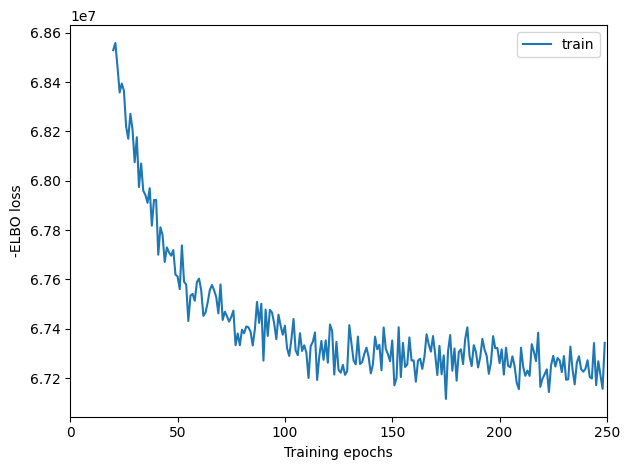

In [25]:
sc_model.plot_history(20)

### Export estimated cell abundance

In [26]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
scadata = sc_model.export_posterior(
    scadata, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
sc_model.save(ref_run_name, overwrite=True)

# Save anndata object with results
adata_file = os.path.join(ref_run_name, "sc.h5ad")
scadata.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:06<00:00, 142.99it/s]


'out/deconvolution/reference_signatures/sc.h5ad'

### Examine QC plots

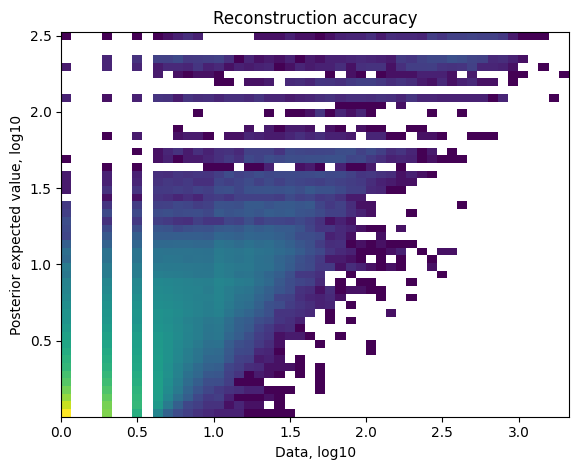

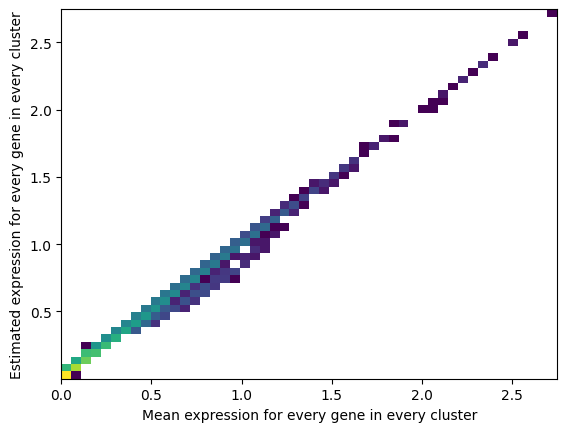

In [27]:
sc_model.plot_QC()

### Reload model and output h5ad

In [28]:
adata_file = os.path.join(ref_run_name, "sc.h5ad")
scadata = sc.read_h5ad(adata_file)
sc_model = cell2location.models.RegressionModel.load(ref_run_name, scadata)

INFO     File out/deconvolution/reference_signatures/model.pt already downloaded             
INFO     Preparing underlying module for load                                                


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (8) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/1000:   0%|          | 1/1000 [00:00<03:02,  5.47it/s, v_num=1, elbo_train=6.88e+7]


### Extract reference cell type signatures as Dataframe

In [30]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in scadata.varm.keys():
    inf_aver = scadata.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in scadata.uns['mod']['factor_names']]].copy()
else:
    inf_aver = scadata.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in scadata.uns['mod']['factor_names']]].copy()
inf_aver.columns = scadata.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,DCT,Early PT,Endo,IC,LOH
Mrpl15,0.156443,0.249407,0.085298,0.329989,0.154286
Lypla1,0.262455,0.726384,0.105602,0.420419,0.199365
Tcea1,0.178806,0.284363,0.152720,0.422746,0.157286
Atp6v1h,0.189341,0.269536,0.088952,1.101244,0.126975
Rb1cc1,0.256749,0.429152,0.140004,0.379466,0.229564


## Cell2location: spatial mapping

### Find shared genes and prepare anndata

In [31]:
inf_avers = {}
for i, stadata in stadatas.items():
    # find shared genes and subset both anndata and reference signatures
    intersect = np.intersect1d(stadata.var_names, inf_aver.index)
    stadatas[i] = stadata[:, intersect].copy()
    inf_avers[i] = inf_aver.loc[intersect, :].copy()

In [32]:
for i, stadata in stadatas.items():
    # prepare anndata for cell2location model
    print("Processing {}...".format(i))
    cell2location.models.Cell2location.setup_anndata(adata=stadata, 
                                                     layer="counts", 
                                                     batch_key="id")

Processing 37_46_B3...
Processing 37_46_C1...


### Create and train model
#### Choosing of hyperparamters:

- `N_cells_per_location`: For Kidney it is about 20
- `detection_alpha`: We use here `detection_alpha=20` to account for technical variability in RNA detection sensitivity.

Processing 37_46_B3...
	Create model


Anndata setup with scvi-tools version 0.16.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'id',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 1116  │
│          n_vars          │ 6010  │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                 batch State Registry                 
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Source Location ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['id'] │  37_46_B3  │          0          │
└─────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

	Start training with seed 0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 30000/30000: 100%|██████████| 30000/30000 [27:11<00:00, 18.39it/s, v_num=1, elbo_train=9.27e+6]
	Plot history


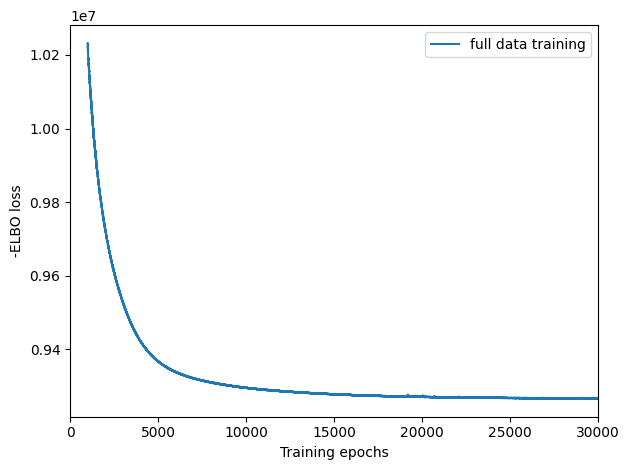

	Export estimated cell abundance
Sampling global variables, sample: 100%|██████████| 999/999 [00:11<00:00, 84.54it/s]
	Save model into out/deconvolution/cell2location_map_37_46_B3
	Save adata into out/deconvolution/cell2location_map_37_46_B3/sp.h5ad
Processing 37_46_C1...
	Create model


Anndata setup with scvi-tools version 0.16.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'id',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 1120  │
│          n_vars          │ 6010  │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                 batch State Registry                 
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Source Location ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['id'] │  37_46_C1  │          0          │
└─────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

	Start training with seed 0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 30000/30000: 100%|██████████| 30000/30000 [25:01<00:00, 19.98it/s, v_num=1, elbo_train=8.56e+6]
	Plot history


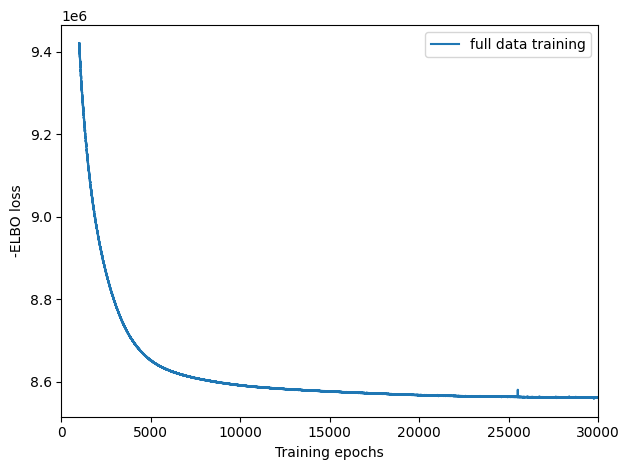

	Export estimated cell abundance
Sampling global variables, sample: 100%|██████████| 999/999 [00:11<00:00, 85.05it/s]
	Save model into out/deconvolution/cell2location_map_37_46_C1
	Save adata into out/deconvolution/cell2location_map_37_46_C1/sp.h5ad


In [33]:
seed = 0
run_names = {}
for i, stadata in stadatas.items():
    print("Processing {}...".format(i), flush=True)
    run_name = os.path.join(results_folder, 'cell2location_map_{}'.format(i))
    run_names[i] = run_name
    
    # create and train the model
    print("\tCreate model")
    st_model = cell2location.models.Cell2location(
        stadata, cell_state_df=inf_avers[i], 
        # the expected average cell abundance: tissue-dependent 
        # hyper-prior which can be estimated from paired histology:
        N_cells_per_location=20,
        # hyperparameter controlling normalisation of
        # within-experiment variation in RNA detection:
        detection_alpha=20
    )

    # view models
    st_model.view_anndata_setup()
    
    # train
    print("\tStart training with seed {}".format(seed), flush=True)
    random.seed(seed) # set seed
    st_model.train(max_epochs=30000, 
                    # train using full data (batch_size=None)
                    batch_size=None, 
                    # use all data points in training because 
                    # we need to estimate cell abundance at all locations
                    train_size=1,
                    use_gpu=True)

    # plot ELBO loss history during training, removing first 100 epochs from the plot
    print("\tPlot history", flush=True)
    st_model.plot_history(1000)
    plt.legend(labels=['full data training'])
    plt.show()

    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    print("\tExport estimated cell abundance")
    stadata = st_model.export_posterior(
        stadata, sample_kwargs={'num_samples': 1000, 
                                'batch_size': st_model.adata.n_obs, 
                                'use_gpu': True}
    )

    # Save model
    print("\tSave model into {}".format(run_name), flush=True)
    st_model.save(run_name, overwrite=True)

    # mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

    # Save anndata object with results
    adata_file = os.path.join(run_name, "sp.h5ad")
    
    print("\tSave adata into {}".format(adata_file), flush=True)
    stadata.write(adata_file)

# Analyze results

### Reload model

In [35]:
# find run name folders
indices = ["37_46_B3", "37_46_C1"]

run_names = {}
for i in indices:
    r = [f for f in glob(os.path.join(results_folder, "*")) if i in f]
    if len(r) == 1:
        run_names[i] = r[0]
    else:
        print("More than one possible match found for `{}`.".format(i))
        run_names[i] = r

In [36]:
run_names

{'37_46_B3': 'out/deconvolution/cell2location_map_37_46_B3',
 '37_46_C1': 'out/deconvolution/cell2location_map_37_46_C1'}

In [37]:
stadatas = {}
st_models = {}

for i, run_name in run_names.items():
    print(i, flush=True)
    adata_file = os.path.join(run_name, "sp.h5ad")
    stadata = sc.read_h5ad(adata_file)
    st_model = cell2location.models.Cell2location.load(run_name, stadata)

    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    # this has to be repeated after the reload
    stadata = st_model.export_posterior(
        stadata, sample_kwargs={'num_samples': 1000, 
                                'batch_size': st_model.adata.n_obs, 
                                'use_gpu': True}
    )
    
    # collect
    stadatas[i] = stadata
    st_models[i] = st_model

37_46_B3
INFO     File out/deconvolution/cell2location_map_37_46_B3/model.pt already downloaded       
INFO     Preparing underlying module for load                                                


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Sampling global variables, sample: 100%|██████████| 999/999 [00:11<00:00, 83.40it/s]
37_46_C1
INFO     File out/deconvolution/cell2location_map_37_46_C1/model.pt already downloaded       
INFO     Preparing underlying module for load                                                


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Sampling global variables, sample: 100%|██████████| 999/999 [00:12<00:00, 82.01it/s]


#### Assessing mapping quality

37_46_B3


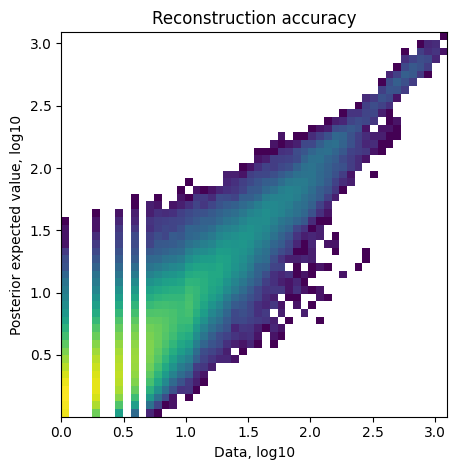

37_46_C1


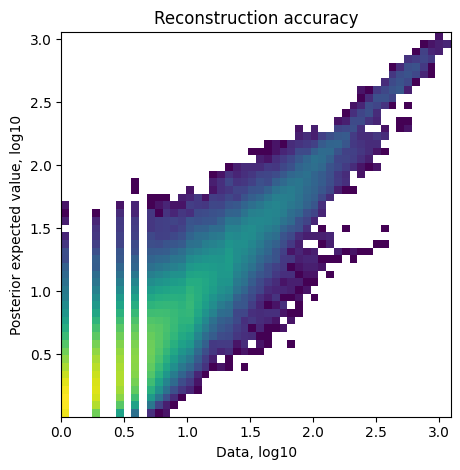

In [38]:
for i, st_model in st_models.items():
    print(i, flush=True)
    st_model.plot_QC()
    plt.show()

## Visualizing cell abundance in spatial coordinates

Note: We use 5% quantile of the posterior distribution, representing the value of cell abundance that the model has high confidence in (aka 'at least this amount is present'). 

In [39]:
rename_dict = {
    "DCT": "Distal convoluted tubules",
    "Early PT": "Early proximal tubules",
    "Endo": "Endothelial cells",
    "IC": "Collecting duct intercalated cells",
    "LOH": "Loop of Henle",
    "Macro": "Macrophages",
    "NP": "Nephron progenitors",
    "Neutro": "Neutrophils",
    "PC": "Collecting duct principal cells",
    "PCT": "Proximal convoluted tubules",
    "PST": "Proximal straight tubules",
    "Podo": "Podocytes",
    "Proliferating": "Proliferating cells",
    "Stroma 1": "Stromal cells 1",
    "Stroma 2": "Stromal cells 2"
}

In [40]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting

for i, stadata in stadatas.items():
    stadata.uns['mod']['factor_names'] = [rename_dict[elem] if elem in rename_dict else elem for elem in stadata.uns['mod']['factor_names']]
    stadata.obs[stadata.uns['mod']['factor_names']] = stadata.obsm['q05_cell_abundance_w_sf']

In [51]:
stadata

AnnData object with n_obs × n_vars = 1120 × 6010
    obs: 'array_row', 'array_col', 'um_row', 'um_col', 'id', 'pixel_row', 'pixel_col', 'dapi_mean', 'dapi_mean_norm', 'experiment_id', 'organism', 'age', 'organ', 'age_months', 'mouse_id', 'exp_date', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'CT010467.1_pct', 'leiden_uncorrected', 'leiden', 'leiden_coarse', '_indices', '_scvi_batch', '_scvi_labels', 'Distal convoluted tubules', 'Early proximal tubules', 'Endothelial cells', 'Collecting duct intercalated cells', 'Loop of Henle', 'Macrophages', 'Nephron progenitors', 'Neutrophils', 'Collecting duct principal cells', 'Proximal convoluted tubules', 'Proximal straight tubules', 'Podocytes', 'Proliferating cells', 'Stromal cells 1', 'Stromal cells 2', 'Unnamed'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_inte

In [50]:
for i, stadata in stadatas.items():
    # get celltypes
    celltypes = stadata.uns['mod']['factor_names']

    db.pl.spatial(stadata, 
                  keys=celltypes, 
                  groupby='id',
                  image_key='phalloidin',
                  cmap='magma', alpha=1, clb_pad=0.05, figsize=(6.5,6),
                  savepath="figures/deconvolution/spatial_cell2location_kidney_{}_celltypes.pdf".format(i), save_only=True
                 )

Saving figure to file figures/deconvolution/spatial_cell2location_kidney_37_46_B3_celltypes.pdf
Saved.
Saving figure to file figures/deconvolution/spatial_cell2location_kidney_37_46_C1_celltypes.pdf
Saved.


### Cell type proportions

37_46_B3


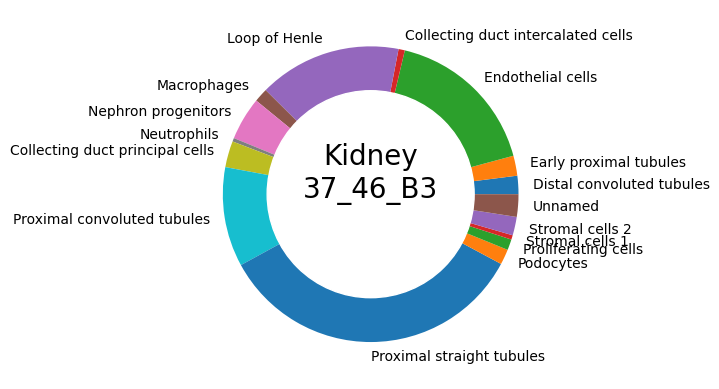

37_46_C1


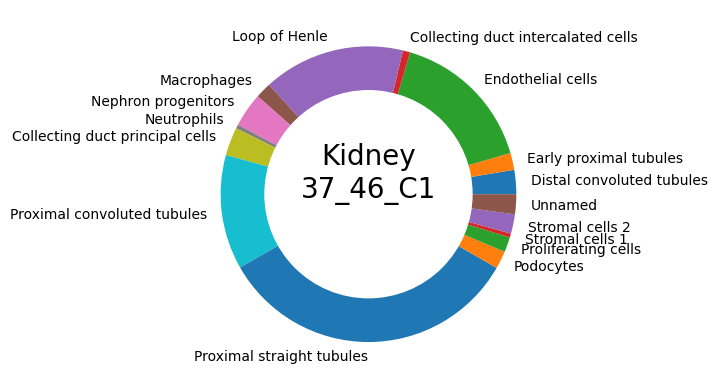

Cell proportions saved into out/deconvolution/cellproportions.xlsx


In [48]:
percdf = {}
for i, stadata in stadatas.items():
    print(i, flush=True)
    # extract percentages
    sum_props = stadata.obsm['q05_cell_abundance_w_sf'].sum()
    sum_props.index = stadata.uns['mod']['factor_names']
    perc = sum_props / sum_props.sum() * 100
    percdf[i] = perc

    # Create a circle at the center of the plot
    my_circle = plt.Circle( (0,0), 0.7, color='white')

    plt.pie(perc, labels=perc.index, 
            #colors=cm.tab20(np.arange(len(perc)))
           )

    p = plt.gcf()
    p.gca().add_artist(my_circle)

    plt.title("Kidney\n{}".format(i), y=0.47, fontsize=20)
    plt.savefig("figures/deconvolution/pie_cell2location_kidney_{}.pdf".format(i))
    plt.show()
    
df_file = "out/deconvolution/cellproportions.xlsx"
percdf = pd.DataFrame(percdf)
percdf.to_excel(df_file)
print("Cell proportions saved into {}".format(df_file))

# Save deconvolved data

In [49]:
for i, stadata in stadatas.items():
    results_file = os.path.join(data_dir, "Kidney-{}-adata-cell2location.h5ad".format(i))
    stadata.write(results_file)